In [1]:
from nemo.collections.tts.models import T5TTS_Model
from nemo.collections.tts.data.text_to_speech_dataset import T5TTSDataset, DatasetSample
from omegaconf.omegaconf import OmegaConf, open_dict
import torch
import os
import soundfile as sf
from IPython.display import display, Audio
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

[NeMo W 2025-02-11 04:53:00 nemo_logging:361] /usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
      from .autonotebook import tqdm as notebook_tqdm
    


### Checkpoint Paths

In [2]:
# Checkpoint and Hparams Paths
# hparams_file = "/datap/misc/icml2025_base_checkpoints/RoyCheckpoints/CML_WithRivaSpanish_NoPolishPortugese_SeparateCharTokenizer_hparams.yaml"
# checkpoint_file = "/datap/misc/icml2025_base_checkpoints/RoyCheckpoints/SeparateCharTokenizer_epoch12_fp32_DPO_3epochs_AllLanguages_0.05_ng1_epoch3.ckpt"


# checkpoint_file = "/datap/misc/ChallengingFinetuneLocalTraining/nosynthlast.ckpt"
hparams_file = "/datap/misc/ChallengingFinetuneLocalTraining/head1hparams.yaml"
checkpoint_file = "/datap/misc/ChallengingFinetuneLocalTraining/head1last.ckpt"


# hparams_file = "/datap/misc/ChallengingFinetuneLocalTraining/royhparams.yaml"
# checkpoint_file = "/datap/misc/ChallengingFinetuneLocalTraining/roy1-5.ckpt"
# checkpoint_file = "/datap/misc/icml2025_base_checkpoints/decodercontext_small_sp_ks3CorrectWithPrior_onlyphoneme_epoch161.ckpt"

codecmodel_path = "/datap/misc/checkpoints/AudioCodec_21Hz_no_eliz.nemo"

# Temp out dir for saving audios
out_dir = "/datap/misc/t5tts_inference_notebook_samples"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Load Model

In [3]:
model_cfg = OmegaConf.load(hparams_file).cfg

with open_dict(model_cfg):
    model_cfg.codecmodel_path = codecmodel_path
    if hasattr(model_cfg, 'text_tokenizer'):
        # Backward compatibility for models trained with absolute paths in text_tokenizer
        model_cfg.text_tokenizer.g2p.phoneme_dict = "scripts/tts_dataset_files/ipa_cmudict-0.7b_nv23.01.txt"
        model_cfg.text_tokenizer.g2p.heteronyms = "scripts/tts_dataset_files/heteronyms-052722"
        model_cfg.text_tokenizer.g2p.phoneme_probability = 1.0
    model_cfg.train_ds = None
    model_cfg.validation_ds = None


model = T5TTS_Model(cfg=model_cfg)
print("Loading weights from checkpoint")
ckpt = torch.load(checkpoint_file)
model.load_state_dict(ckpt['state_dict'])
print("Loaded weights.")

model.use_kv_cache_for_inference = True

model.cuda()
model.eval()

[NeMo W 2025-02-11 04:53:04 experimental:26] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2025-02-11 04:53:06 i18n_ipa:124] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-02-11 04:53:06 experimental:26] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'>` is experimental and not ready for production yet. Use at your own risk.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be

[NeMo I 2025-02-11 04:53:10 audio_codec:101] Vector quantizer does not support commit loss.
[NeMo I 2025-02-11 04:53:11 features:305] PADDING: 1
[NeMo I 2025-02-11 04:53:11 features:305] PADDING: 1
[NeMo I 2025-02-11 04:53:11 features:305] PADDING: 1
[NeMo I 2025-02-11 04:53:11 features:305] PADDING: 1
[NeMo I 2025-02-11 04:53:11 features:305] PADDING: 1
[NeMo I 2025-02-11 04:53:11 features:305] PADDING: 1
[NeMo I 2025-02-11 04:53:11 features:305] PADDING: 1
[NeMo I 2025-02-11 04:53:12 save_restore_connector:275] Model AudioCodecModel was successfully restored from /datap/misc/checkpoints/AudioCodec_21Hz_no_eliz.nemo.
Loading weights from checkpoint
Loaded weights.


T5TTS_Model(
  (audio_embeddings): ModuleList(
    (0-7): 8 x Embedding(2048, 768)
  )
  (text_embedding): Embedding(98, 768)
  (t5_encoder): Transformer(
    (dropout): Dropout(p=0.1, inplace=False)
    (norm_out): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x TransformerLayer(
        (norm_self): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (self_attention): SelfAttention(
          (o_net): Linear(in_features=768, out_features=768, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (qkv_net): Linear(in_features=768, out_features=2304, bias=False)
        )
        (norm_pos_ff): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (pos_ff): PositionwiseConvFF(
          (non_linearity): GELU(approximate='tanh')
          (proj): ConvolutionLayer(
            (conv): Conv1d(768, 3072, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          )
          (o_net): ConvolutionLay

### Initialize Dataset class and helper functions

In [4]:
test_dataset = T5TTSDataset(
    dataset_meta={},
    sample_rate=model_cfg.sample_rate,
    min_duration=0.5,
    max_duration=20,
    codec_model_downsample_factor=model_cfg.codec_model_downsample_factor,
    bos_id=model.bos_id,
    eos_id=model.eos_id,
    context_audio_bos_id=model.context_audio_bos_id,
    context_audio_eos_id=model.context_audio_eos_id,
    audio_bos_id=model.audio_bos_id,
    audio_eos_id=model.audio_eos_id,
    num_audio_codebooks=model_cfg.num_audio_codebooks,
    prior_scaling_factor=None,
    load_cached_codes_if_available=True,
    dataset_type='test',
    tokenizer_config=None,
    load_16khz_audio=model.model_type == 'single_encoder_sv_tts',
    use_text_conditioning_tokenizer=model.use_text_conditioning_encoder,
    pad_context_text_to_max_duration=model.pad_context_text_to_max_duration,
    context_duration_min=model.cfg.get('context_duration_min', 5.0),
    context_duration_max=model.cfg.get('context_duration_max', 5.0),
)
test_dataset.text_tokenizer, test_dataset.text_conditioning_tokenizer = model._setup_tokenizers(model.cfg, mode='test')



def get_audio_duration(file_path):
    with sf.SoundFile(file_path) as audio_file:
        # Calculate the duration
        duration = len(audio_file) / audio_file.samplerate
        return duration

def create_record(text, context_audio_filepath=None, context_text=None):
    dummy_audio_fp = os.path.join(out_dir, "dummy_audio.wav")
    dummy_audio = sf.write(dummy_audio_fp, np.zeros(22050 * 3), 22050)  # 3 seconds of silence
    record = {
        'audio_filepath' : dummy_audio_fp,
        'duration': 3.0,
        'text': text,
        'speaker': "dummy",
    }
    if context_text is not None:
        assert context_audio_filepath is None
        record['context_text'] = context_text
    else:
        assert context_audio_filepath is not None
        record['context_audio_filepath'] = context_audio_filepath
        record['context_audio_duration'] = get_audio_duration(context_audio_filepath)
    
    return record

[NeMo W 2025-02-11 04:53:14 experimental:26] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2025-02-11 04:53:16 i18n_ipa:124] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-02-11 04:53:16 experimental:26] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'>` is experimental and not ready for production yet. Use at your own risk.


### Set transcript and context pairs to test

In [42]:
# Change sample text and prompt audio/text here
audio_base_dir = "/"
test_entries = [
    create_record(
        text="This is a simple sentence to check which attention heads learn text to speech alignment. And detect attention sinks if any.",
        context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
    ),
    create_record(
        text="His phone number is one one one one, nine nine nine nine nine, nine nine, nine, right",
        context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
    ),
    create_record(
        text="Let me confirm S D S D two two two two one two four four h t t p four five six seven eight. Is that correct?",
#         context_audio_filepath="/datap/misc/LibriTTSfromNemo/LibriTTS/test-clean/3729/6852/3729_6852_000084_000003.wav", # Supply either context_audio_filepath or context_text, not both
        context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
    ),
    create_record(
        text="S D S D Pass zero - zero Fail - zero to zero - zero - zero Cancelled - fifty nine to three - two - sixty four Total - fifty nine to three - two -",
        context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
    ),
    create_record(
        text="This is an example of a regular text without any challlenging texts like repeated words or numbers just to do a sanity check.",
        context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
    ),
    create_record(
        text="has confidence in the dedicated Secret Service men who are ready to lay down their lives for him and make an amendment and make another amendment",
        context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
    ),
    create_record(
        text="Hi, my phone number is eight five eight, two five seven, nine nine five four. Please transfer me five hundred and fifty five dollars on february seventh",
        context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
    ),

    create_record(
        text="To deliver interfaces that are significantly better suited to create and process R F C eight twenty one, R F C eight twenty two, R F C nine seventy seven, and MIME content.",
        context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
    ),
]

data_samples = []
for entry in test_entries:
    dataset_sample = DatasetSample(
        dataset_name="sample",
        manifest_entry=entry,
        audio_dir=audio_base_dir,
        feature_dir=audio_base_dir,
        text=entry['text'],
        speaker=None,
        speaker_index=0,
        tokenizer_names=["english_phoneme"], # Change this for multilingual: "english_phoneme", "spanish_phoneme", "english_chartokenizer", "german_chartokenizer".. 
    )
    data_samples.append(dataset_sample)
    
test_dataset.data_samples = data_samples

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=test_dataset.collate_fn,
    num_workers=0,
    shuffle=False
)

### Generate With Prior

Processing batch 0 out of 8
End detected for item 0 at timestep 157
All ends reached
generation time 3.068352460861206
This is a simple sentence to check which attention heads learn text to speech alignment. And detect attention sinks if any.
Prior Used? True


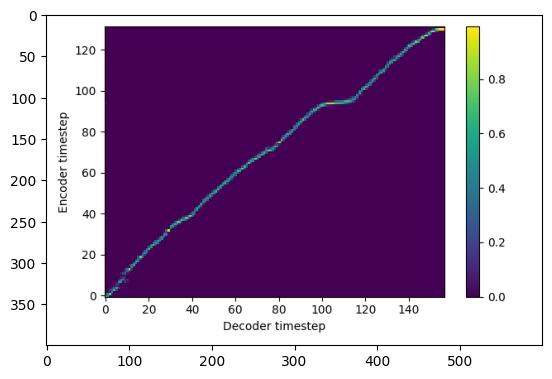

------------------------------------
------------------------------------
End detected for item 0 at timestep 154
All ends reached
generation time 6.042356729507446
This is a simple sentence to check which attention heads learn text to speech alignment. And detect attention sinks if any.
Prior Used? False


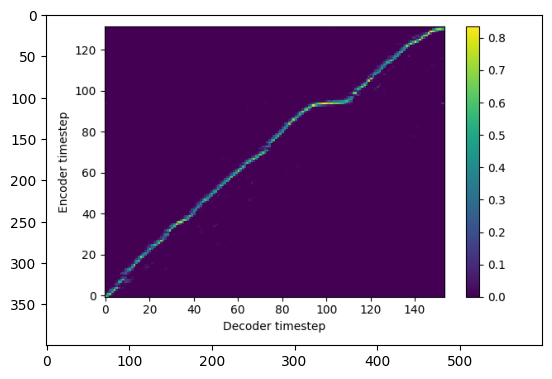

------------------------------------
------------------------------------
Processing batch 1 out of 8
End detected for item 0 at timestep 152
All ends reached
generation time 2.9235787391662598
His phone number is one one one one, nine nine nine nine nine, nine nine, nine, right
Prior Used? True


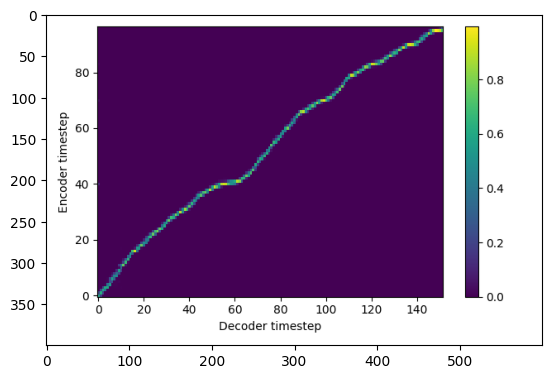

------------------------------------
------------------------------------
End detected for item 0 at timestep 134
All ends reached
generation time 5.537024259567261
His phone number is one one one one, nine nine nine nine nine, nine nine, nine, right
Prior Used? False


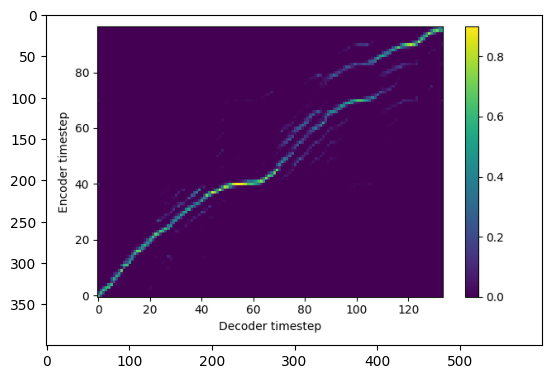

------------------------------------
------------------------------------
Processing batch 2 out of 8
End detected for item 0 at timestep 174
All ends reached
generation time 3.3312580585479736
Let me confirm S D S D two two two two one two four four h t t p four five six seven eight. Is that correct?
Prior Used? True


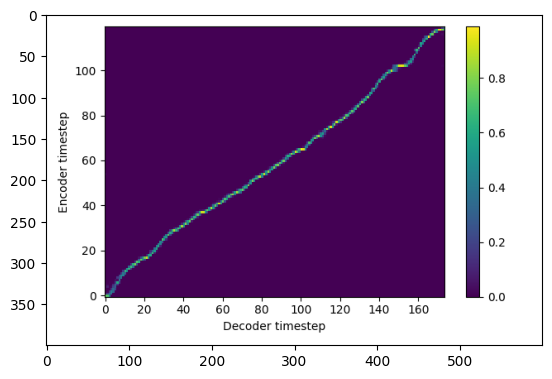

------------------------------------
------------------------------------
End detected for item 0 at timestep 170
All ends reached
generation time 6.572901010513306
Let me confirm S D S D two two two two one two four four h t t p four five six seven eight. Is that correct?
Prior Used? False


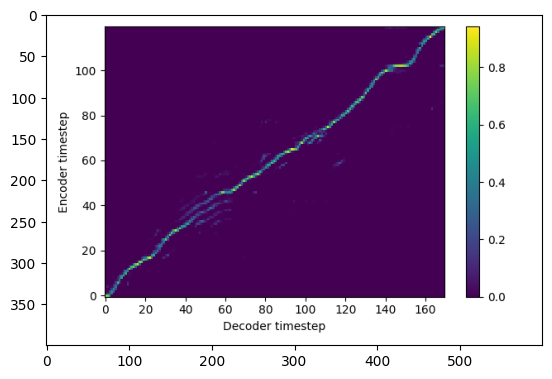

------------------------------------
------------------------------------
Processing batch 3 out of 8
End detected for item 0 at timestep 267
All ends reached
generation time 4.982589960098267
S D S D Pass zero - zero Fail - zero to zero - zero - zero Cancelled - fifty nine to three - two - sixty four Total - fifty nine to three - two -
Prior Used? True


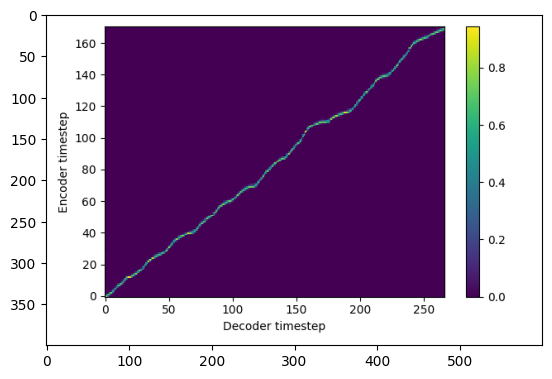

------------------------------------
------------------------------------
End detected for item 0 at timestep 276
All ends reached
generation time 10.139357089996338
S D S D Pass zero - zero Fail - zero to zero - zero - zero Cancelled - fifty nine to three - two - sixty four Total - fifty nine to three - two -
Prior Used? False


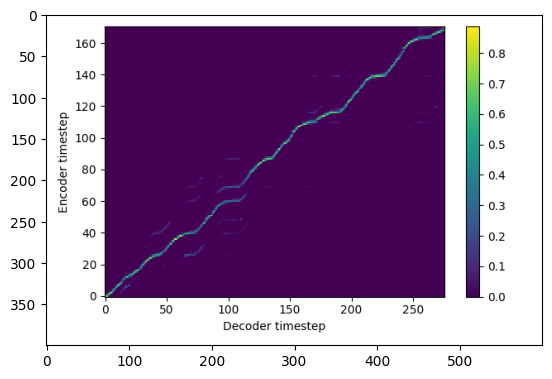

------------------------------------
------------------------------------
Processing batch 4 out of 8
End detected for item 0 at timestep 155
All ends reached
generation time 3.043395519256592
This is an example of a regular text without any challlenging texts like repeated words or numbers just to do a sanity check.
Prior Used? True


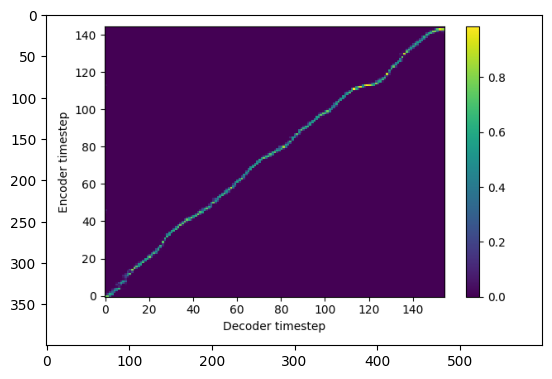

------------------------------------
------------------------------------
End detected for item 0 at timestep 146
All ends reached
generation time 5.901343822479248
This is an example of a regular text without any challlenging texts like repeated words or numbers just to do a sanity check.
Prior Used? False


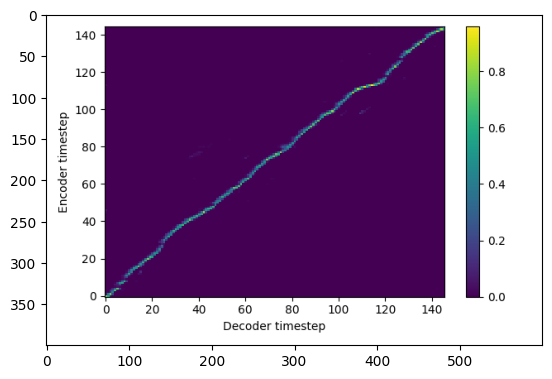

------------------------------------
------------------------------------
Processing batch 5 out of 8
End detected for item 0 at timestep 173
All ends reached
generation time 3.381603717803955
has confidence in the dedicated Secret Service men who are ready to lay down their lives for him and make an amendment and make another amendment
Prior Used? True


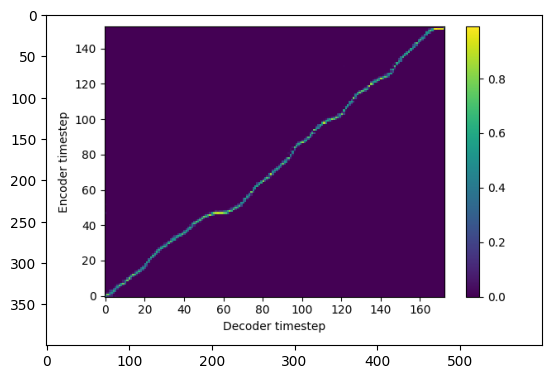

------------------------------------
------------------------------------
End detected for item 0 at timestep 161
All ends reached
generation time 6.605531215667725
has confidence in the dedicated Secret Service men who are ready to lay down their lives for him and make an amendment and make another amendment
Prior Used? False


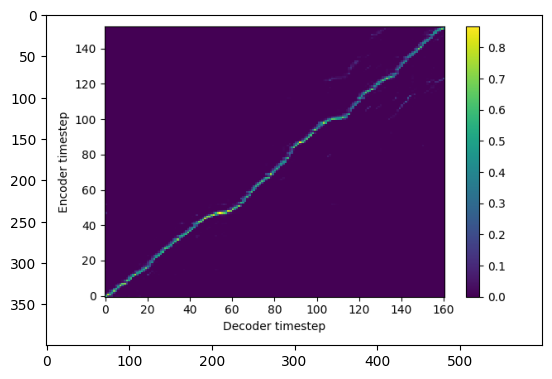

------------------------------------
------------------------------------
Processing batch 6 out of 8
End detected for item 0 at timestep 204
All ends reached
generation time 3.9206278324127197
Hi, my phone number is eight five eight, two five seven, nine nine five four. Please transfer me five hundred and fifty five dollars on february seventh
Prior Used? True


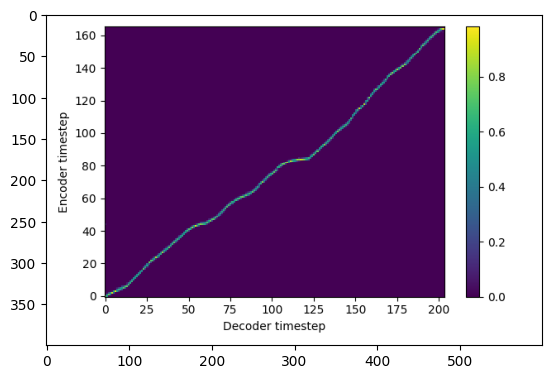

------------------------------------
------------------------------------
End detected for item 0 at timestep 207
All ends reached
generation time 7.795541286468506
Hi, my phone number is eight five eight, two five seven, nine nine five four. Please transfer me five hundred and fifty five dollars on february seventh
Prior Used? False


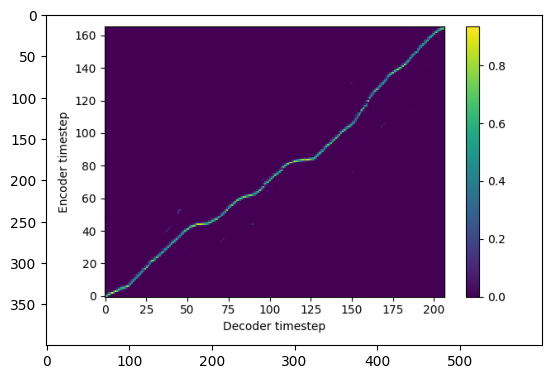

------------------------------------
------------------------------------
Processing batch 7 out of 8
End detected for item 0 at timestep 247
All ends reached
generation time 4.613217830657959
To deliver interfaces that are significantly better suited to create and process R F C eight twenty one, R F C eight twenty two, R F C nine seventy seven, and MIME content.
Prior Used? True


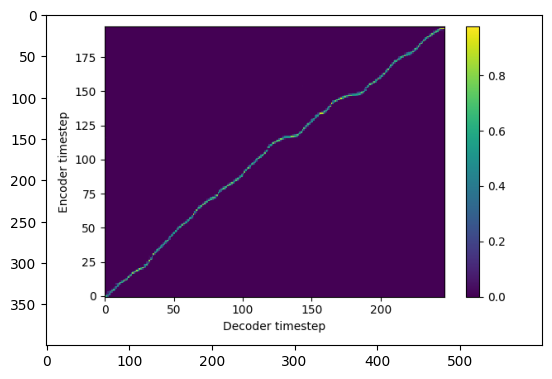

------------------------------------
------------------------------------
End detected for item 0 at timestep 251
All ends reached
generation time 9.271058320999146
To deliver interfaces that are significantly better suited to create and process R F C eight twenty one, R F C eight twenty two, R F C nine seventy seven, and MIME content.
Prior Used? False


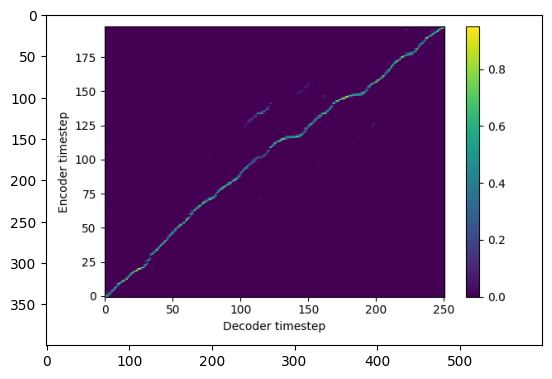

------------------------------------
------------------------------------


In [43]:
import matplotlib.pyplot as plt

item_idx = 0
for bidx, batch in enumerate(test_data_loader):
    print("Processing batch {} out of {}".format(bidx, len(test_data_loader)))
    model.t5_decoder.reset_cache(use_cache=True)
    batch_cuda ={}
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch_cuda[key] = batch[key].cuda()
        else:
            batch_cuda[key] = batch[key]
    import time
    st = time.time()
    
    for apply_prior in [True, False]:
        predicted_audio, predicted_audio_lens, _, _, cross_attn_np, all_heads_attn_np = model.infer_batch(
            batch_cuda, 
            max_decoder_steps=500, 
            temperature=0.5, 
            topk=80, 
            use_cfg=True,
            cfg_scale=2.5,
            prior_epsilon=1e-3,
            lookahead_window_size=3,
            return_cross_attn_probs=True,
            apply_attention_prior=apply_prior,
            apply_prior_to_layers=[3,4,5,6,7],
#             compute_all_heads_attn_maps=True,
        )
        print("generation time", time.time() - st)
        for idx in range(predicted_audio.size(0)):
            predicted_audio_np = predicted_audio[idx].float().detach().cpu().numpy()
            predicted_audio_np = predicted_audio_np[:predicted_audio_lens[idx]]
            audio_path = os.path.join(out_dir, f"predicted_audio_{item_idx}.wav")
            sf.write(audio_path, predicted_audio_np, model.cfg.sample_rate)
            print(test_entries[bidx]['text'])
            print("Prior Used?", apply_prior)
            display(Audio(audio_path))
            item_idx += 1
            plt.imshow(cross_attn_np[idx])
            plt.show()
#             for hidx, head_cross_attn in enumerate(all_heads_attn_np[idx]):
#                 layer_num = hidx // model.cfg.t5_decoder.xa_n_heads
#                 head_num = hidx % model.cfg.t5_decoder.xa_n_heads
#                 print("item, layer, head", idx, layer_num, head_num)
#                 plt.imshow(all_heads_attn_np[idx][hidx])
#                 plt.show()
                
        print("------------------------------------")
        print("------------------------------------")